code borrowed from 

    https://github.com/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mdn-cls.ipynb
    
# OOD MNIST

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.6.0].
device:[cuda:0].


# MLN

In [2]:
class MixtureOfLogits(nn.Module):
    def __init__(self,
                 in_dim     = 64,   # input feature dimension 
                 y_dim      = 10,   # number of classes 
                 k          = 5,    # number of mixtures
                 sig_min    = 1e-4, # minimum sigma
                 sig_max    = None, # maximum sigma
                 SHARE_SIG  = True  # share sigma among mixture
                 ):
        super(MixtureOfLogits,self).__init__()
        self.in_dim     = in_dim    # Q
        self.y_dim      = y_dim     # D
        self.k          = k         # K
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()

    def build_graph(self):
        self.fc_pi      = nn.Linear(self.in_dim,self.k)
        self.fc_mu      = nn.Linear(self.in_dim,self.k*self.y_dim)
        if self.SHARE_SIG:
            self.fc_sigma   = nn.Linear(self.in_dim,self.k)
        else:
            self.fc_sigma   = nn.Linear(self.in_dim,self.k*self.y_dim)

    def forward(self,x):
        """
            :param x: [N x Q]
        """
        pi_logit        = self.fc_pi(x)                                 # [N x K]
        pi              = torch.softmax(pi_logit,dim=1)                 # [N x K]
        mu              = self.fc_mu(x)                                 # [N x KD]
        mu              = torch.reshape(mu,(-1,self.k,self.y_dim))      # [N x K x D]
        #mu              = F.sigmoid(mu)
        mu              = F.softmax(mu, dim=-1)
        if self.SHARE_SIG:
            sigma       = self.fc_sigma(x)                              # [N x K]
            sigma       = sigma.unsqueeze(dim=-1)                       # [N x K x 1]
            sigma       = sigma.expand_as(mu)                           # [N x K x D]
        else:
            sigma       = self.fc_sigma(x)                              # [N x KD]
        sigma           = torch.reshape(sigma,(-1,self.k,self.y_dim))   # [N x K x D]
        if self.sig_max is None:
            sigma = self.sig_min + torch.exp(sigma)                     # [N x K x D]
        else:
            sig_range = (self.sig_max-self.sig_min)
            sigma = self.sig_min + sig_range*torch.sigmoid(sigma)       # [N x K x D]
        mol_out = {'pi':pi,'mu':mu,'sigma':sigma}
        return mol_out

In [3]:
class MixtureLogitNetwork(nn.Module):
    def __init__(self,
                 name       = 'mln',        # name
                 x_dim      = [1,28,28],    # input dimension
                 k_size     = 3,            # kernel size
                 c_dims     = [32,64],      # conv channel dimensions
                 p_sizes    = [2,2],        # pooling sizes
                 h_dims     = [128],        # hidden dimensions
                 y_dim      = 10,           # output dimension
                 USE_BN     = True,         # whether to use batch-norm
                 k          = 5,            # number of mixtures
                 sig_min    = 1e-4,         # minimum sigma
                 sig_max    = 10,           # maximum sigma
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                 SHARE_SIG  = True          
                 ):
        super(MixtureLogitNetwork,self).__init__()
        self.name       = name
        self.x_dim      = x_dim
        self.k_size     = k_size
        self.c_dims     = c_dims
        self.p_sizes    = p_sizes
        self.h_dims     = h_dims
        self.y_dim      = y_dim
        self.USE_BN     = USE_BN
        self.k          = k
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.mu_min     = mu_min
        self.mu_max     = mu_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()
        self.init_param()

    def build_graph(self):
        self.layers = []
        # Conv layers
        prev_c_dim = self.x_dim[0] # input channel 
        for (c_dim,p_size) in zip(self.c_dims,self.p_sizes):
            self.layers.append(
                nn.Conv2d(
                    in_channels  = prev_c_dim,
                    out_channels = c_dim,
                    kernel_size  = self.k_size,
                    stride       = (1,1),
                    padding      = self.k_size//2
                    ) # conv
                )
            if self.USE_BN:
                self.layers.append(
                    nn.BatchNorm2d(num_features=c_dim)
                )
            self.layers.append(nn.ReLU())
            self.layers.append(
                nn.MaxPool2d(kernel_size=(p_size,p_size),stride=(p_size,p_size))
                )
            # self.layers.append(nn.Dropout2d(p=0.1))  # p: to be zero-ed
            prev_c_dim = c_dim 
        # Dense layers
        self.layers.append(nn.Flatten())
        p_prod = np.prod(self.p_sizes)
        prev_h_dim = prev_c_dim*(self.x_dim[1]//p_prod)*(self.x_dim[2]//p_prod)
        for h_dim in self.h_dims:
            self.layers.append(
                nn.Linear(
                    in_features  = prev_h_dim,
                    out_features = h_dim,
                    bias         = True
                    )
                )
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.Dropout2d(p=0.1))  # p: to be zero-ed
            prev_h_dim = h_dim
        # Final mixture of logits layer
        mol = MixtureOfLogits(
            in_dim      = prev_h_dim,  
            y_dim       = self.y_dim, 
            k           = self.k,
            sig_min     = self.sig_min,
            sig_max     = self.sig_max,
            SHARE_SIG   = self.SHARE_SIG
        )
        self.layers.append(mol)
        # Concatanate all layers
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)

    def forward(self,x):
        mln_out = self.net(x)
        return mln_out # mu:[N x K x D] / pi:[N x K] / sigma:[N x K x D]

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        self.layers[-1].fc_mu.bias.data.uniform_(self.mu_min,self.mu_max)

# Loss

In [4]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy()

def mln_gather(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    max_idx = torch.argmax(pi,dim=1) # [N]
    idx_gather = max_idx.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1) # [N x 1 x D]
    mu_sel = torch.gather(mu,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    sigma_sel = torch.gather(sigma,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    out = {'max_idx':max_idx, # [N]
           'idx_gather':idx_gather, # [N x 1 x D]
           'mu_sel':mu_sel, # [N x D]
           'sigma_sel':sigma_sel # [N x D]
           }
    return out

def mace_loss(pi,mu,sigma,target):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
        :param target:  [N x D]
    """
    # $\mu$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    log_mu_hat = torch.log(mu_hat+1e-6) # [N x K x D]
    # $\pi$
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(mu) # [N x K x D]
    # target
    target_usq =  torch.unsqueeze(target,1) # [N x 1 x D]
    target_exp =  target_usq.expand_as(mu) # [N x K x D]
    # CE loss
    ce_exp = -target_exp*log_mu_hat # CE [N x K x D]
    ace_exp = ce_exp / sigma # attenuated CE [N x K x D]
    mace_exp = torch.mul(pi_exp,ace_exp) # mixtured attenuated CE [N x K x D]
    mace = torch.sum(mace_exp,dim=1) # [N x D]
    mace = torch.sum(mace,dim=1) # [N]
    mace_avg = torch.mean(mace) # [1]
    # Compute uncertainties (epis and alea)
    unct_out = mln_uncertainties(pi,mu,sigma)
    epis = unct_out['epis'] # [N]
    alea = unct_out['alea'] # [N]
    epis_avg = torch.mean(epis) # [1]
    alea_avg = torch.mean(alea) # [1]
    # Return
    loss_out = {'mace':mace, # [N]
                'mace_avg':mace_avg, # [1]
                'epis':epis, # [N]
                'alea':alea, # [N]
                'epis_avg':epis_avg, # [1]
                'alea_avg':alea_avg # [1]
                }
    return loss_out

def mln_uncertainties(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    # $\pi$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(sigma) # [N x K x D]
    # softmax($\mu$) average
    mu_hat_avg = torch.sum(torch.mul(pi_exp,mu_hat),dim=1).unsqueeze(1) # [N x 1 x D]
    mu_hat_avg_exp = mu_hat_avg.expand_as(mu) # [N x K x D]
    mu_hat_diff_sq = torch.square(mu_hat-mu_hat_avg_exp) # [N x K x D]
    # Epistemic uncertainty
    epis = torch.sum(torch.mul(pi_exp,mu_hat_diff_sq), dim=1)  # [N x D]
    epis = torch.sqrt(torch.sum(epis,dim=1)) # [N]
    # Aleatoric uncertainty
    alea = torch.sum(torch.mul(pi_exp,sigma), dim=1)  # [N x D]
    alea = torch.sqrt(torch.mean(alea,dim=1)) # [N]
    # Return
    unct_out = {'epis':epis, # [N]
                'alea':alea  # [N]
                }
    return unct_out
    
# Demo forward path of MLN
M           = MixtureLogitNetwork(k=3,SHARE_SIG=True).to(device)
x           = torch.rand([2]+M.x_dim).to(device)
target      = F.one_hot(torch.randint(low=0,high=10,size=(2,)),num_classes=10).to(device) 
mln_out     = M.forward(x)
pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
mu_sel      = mln_gather(pi,mu,sigma)['mu_sel']
loss_out    = mace_loss(pi,mu,sigma,target)
loss        = loss_out['mace_avg'] - loss_out['epis_avg'] # epis as a regularizer 
loss.backward() # backward propagation 
print ("x:       %s"%(tc2np(x).shape,))
print ("=>")
print ("pi:    %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("mu:    %s\n%s"%(tc2np(mu).shape,tc2np(mu)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("=>")
print ("mace:[%.3f] epis:[%.3f] alea:[%.3f]"%
       (loss_out['mace_avg'],loss_out['epis_avg'],loss_out['alea_avg']))



x:       (2, 1, 28, 28)
=>
pi:    (2, 3)
[[0.062 0.212 0.726]
 [0.073 0.021 0.905]]
mu:    (2, 3, 10)
[[[6.368e-02 1.036e-04 3.722e-04 7.617e-04 7.501e-04 1.484e-03 5.158e-03
   8.752e-01 4.980e-02 2.683e-03]
  [2.122e-01 4.795e-01 1.408e-01 2.375e-02 3.134e-04 3.010e-02 3.779e-04
   1.088e-01 2.566e-03 1.749e-03]
  [3.708e-01 1.987e-03 2.021e-04 1.708e-02 3.648e-02 4.240e-03 9.983e-04
   2.858e-02 3.283e-01 2.113e-01]]

 [[6.635e-01 3.846e-04 2.753e-03 2.025e-03 3.040e-03 4.388e-02 1.357e-02
   9.668e-02 1.712e-01 2.918e-03]
  [2.867e-02 3.289e-01 1.892e-01 3.032e-02 1.482e-03 3.360e-01 1.283e-03
   4.321e-02 3.343e-03 3.758e-02]
  [6.907e-01 1.535e-03 1.237e-04 8.106e-03 3.026e-02 9.399e-04 8.535e-04
   5.637e-02 6.324e-02 1.478e-01]]]
sigma: (2, 3, 10)
[[[4.298 4.298 4.298 4.298 4.298 4.298 4.298 4.298 4.298 4.298]
  [5.523 5.523 5.523 5.523 5.523 5.523 5.523 5.523 5.523 5.523]
  [4.268 4.268 4.268 4.268 4.268 4.268 4.268 4.268 4.268 4.268]]

 [[3.672 3.672 3.672 3.672 3.672 3.672 3

# Dataset

In [5]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
mnist_train.targets = mnist_train.targets # manipulate train labels
BATCH_SIZE = 64
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


In [6]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        y_probs= list()
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt      = batch_out.to(device)
            mln_out     = model.forward(batch_in.view(-1,1,28,28).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out         = mln_gather(pi,mu,sigma)
            model_pred  = out['mu_sel'] # [B x N]
 
            # Compute uncertainty 
            unct_out    = mln_uncertainties(pi,mu,sigma)
            epis_unct   = unct_out['epis'] # [N]
            alea_unct   = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            y_prob,y_pred    = torch.max(model_pred,1)
            n_correct   += (y_pred==y_trgt).sum().item()
            n_total     += batch_in.size(0)
            
            y_probs += list(y_prob.cpu().numpy())
            
        val_accr  = (n_correct/n_total)
        epis      = (epis_unct_sum/n_total).detach().cpu().item()
        alea      = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea, 'y_prob' : y_probs}
    return out_eval

## Train to detect Out-of-distribution

train procedure
1. train 0~4 label only
2. evaluate uncertainity for 0~4 label in test dataset
3. evaluate uncertainity for 5~9 label in test dataset

In [7]:
# make wrapper class for label selection

class MNIST_select(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset, select=[0,1,2,3,4]):
        self.x = list()
        self.y = list()
        self.select = select
        for i in range(len(mnist_dataset)):
            x,y = mnist_dataset[i][0],mnist_dataset[i][1]
            if(y in select):
                self.x.append(x)
                self.y.append(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

In [8]:
mnist_label0to4_train = MNIST_select(mnist_train, select=[0,1,2,3,4])
mnist_label0to4_test = MNIST_select(mnist_test, select=[0,1,2,3,4])
mnist_label5to9_test = MNIST_select(mnist_test, select=[5,6,7,8,9])

In [9]:
print('train split : ',len(mnist_train),'->',len(mnist_label0to4_train))
print('test split : ',len(mnist_label0to4_test), len(mnist_label5to9_test))

train split :  60000 -> 30596
test split :  5139 4861


In [10]:
np.random.seed(seed=0)
torch.manual_seed(seed=0)
MLN_0to4 = MixtureLogitNetwork(name='mln',x_dim=[1,28,28],k_size=5,c_dims=[32,64,128],p_sizes=[2,2,2],
                            h_dims=[128,64],y_dim=10,USE_BN=False,k=5,
                            sig_min=1.0,sig_max=None, 
                            mu_min=-1,mu_max=+1,SHARE_SIG=True).to(device)
MLN_0to4.init_param()
optm = optim.AdamW(MLN_0to4.parameters(),lr=1e-4,weight_decay=5e-6)
MLN_0to4.train() # train mode

# Re-define the train iterator
BATCH_SIZE = 128
train_iter = torch.utils.data.DataLoader(mnist_label0to4_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter_1 = torch.utils.data.DataLoader(mnist_label0to4_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter_2 = torch.utils.data.DataLoader(mnist_label5to9_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)


EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_sum = 0.0
    for batch_in,batch_out in train_iter:
        # Forward path
        mln_out = MLN_0to4.forward(batch_in.view(-1,1,28,28).to(device)) 
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        target = torch.eye(M.y_dim)[batch_out].to(device)
        loss_out = mace_loss(pi,mu,sigma,target) # 'mace_avg','epis_avg','alea_avg'
        loss = loss_out['mace_avg'] - 1e-6*loss_out['epis_avg'] + loss_out['alea_avg']
        # Update
        optm.zero_grad() # reset gradient 
        loss.backward() # back-propagation 
        optm.step() # optimizer update
        # Track losses 
        loss_sum += loss
    loss_avg = loss_sum/len(train_iter)
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_res = func_eval(MLN_0to4,train_iter,device)
        test_res_1  = func_eval(MLN_0to4,test_iter_1,device)
        test_res_2  = func_eval(MLN_0to4,test_iter_2,device)
        print ("epoch:[%d/%d] loss:[%.3f] train_accr:[%.3f] test_accr(0~4):[%.3f] test_accr(5~9):[%.3f]."%
                (epoch,EPOCHS,loss_avg,train_res['val_accr'],test_res_1['val_accr'],test_res_2['val_accr'])) 
        print (" [Train] alea:[%.3f] epis:[%.3f] \n [Test](0~4) alea:[%.3f] epis:[%.3f] \n [Test](5~9) alea:[%.3f] epis:[%.3f]"%
                (train_res['alea'],train_res['epis'],test_res_1['alea'],test_res_1['epis'],test_res_2['alea'],test_res_2['epis']))

print ("Done")

epoch:[0/10] loss:[2.353] train_accr:[0.968] test_accr(0~4):[0.978] test_accr(5~9):[0.000].
 [Train] alea:[1.415] epis:[0.015] 
 [Test](0~4) alea:[1.415] epis:[0.015] 
 [Test](5~9) alea:[1.488] epis:[0.034]
epoch:[1/10] loss:[2.201] train_accr:[0.983] test_accr(0~4):[0.990] test_accr(5~9):[0.000].
 [Train] alea:[1.422] epis:[0.009] 
 [Test](0~4) alea:[1.421] epis:[0.008] 
 [Test](5~9) alea:[1.489] epis:[0.035]
epoch:[2/10] loss:[2.180] train_accr:[0.987] test_accr(0~4):[0.992] test_accr(5~9):[0.000].
 [Train] alea:[1.423] epis:[0.007] 
 [Test](0~4) alea:[1.423] epis:[0.006] 
 [Test](5~9) alea:[1.473] epis:[0.035]
epoch:[3/10] loss:[2.170] train_accr:[0.992] test_accr(0~4):[0.996] test_accr(5~9):[0.000].
 [Train] alea:[1.429] epis:[0.006] 
 [Test](0~4) alea:[1.429] epis:[0.005] 
 [Test](5~9) alea:[1.485] epis:[0.032]
epoch:[4/10] loss:[2.164] train_accr:[0.993] test_accr(0~4):[0.996] test_accr(5~9):[0.000].
 [Train] alea:[1.425] epis:[0.005] 
 [Test](0~4) alea:[1.425] epis:[0.004] 
 [Te

In [11]:
def func_eval_ood(model,data_iter,device):
    indist = [0,1,2,3,4]
    outdist = [5,6,7,8,9]
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        y_probs,y_trues= list(),list()
        epis_ = list()
        alea_ = list()
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt      = batch_out.to(device)
            mln_out     = model.forward(batch_in.view(-1,1,28,28).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out         = mln_gather(pi,mu,sigma)
            model_pred  = out['mu_sel'] # [B x N]
 
            # Compute uncertainty 
            unct_out    = mln_uncertainties(pi,mu,sigma)
            epis_unct   = unct_out['epis'] # [N]
            alea_unct   = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            
            _,y_pred = torch.max(model_pred,1)
            indist_  = (0==y_trgt)| (1==y_trgt) | (2==y_trgt) | (3==y_trgt) | (4==y_trgt)
            outdist_  = (5==y_trgt)| (6==y_trgt) | (7==y_trgt) | (8==y_trgt) | (9==y_trgt)
            indist_  = indist_.long()
            outdist_  = outdist_.long()
            n_correct   += (y_pred==y_trgt).sum().item()
            n_total     += batch_in.size(0)
            
            epis_ += list(epis_unct.cpu().numpy())
            alea_ += list(alea_unct.cpu().numpy())
            y_trues += list(outdist_.cpu().numpy())
            
        val_accr  = (n_correct/n_total)
        epis      = (epis_unct_sum/n_total).detach().cpu().item()
        alea      = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea, 'epis_' : epis_,'alea_' : alea_, 'y_true':y_trues}
    return out_eval

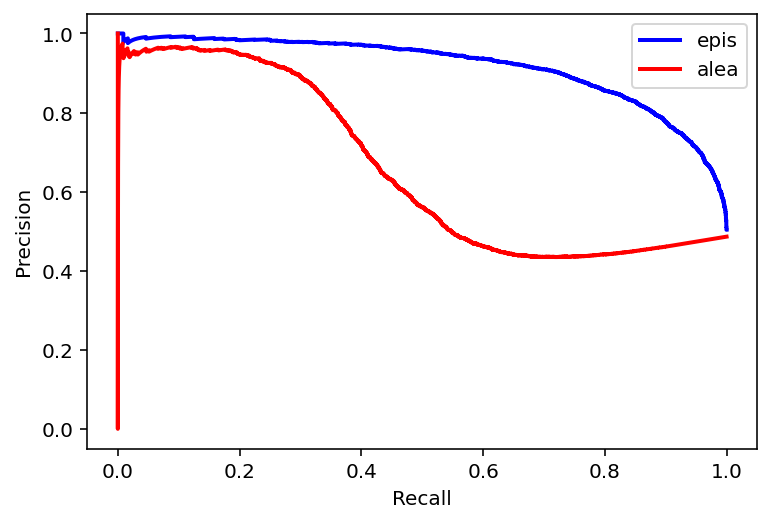

In [12]:
from sklearn.metrics import precision_recall_curve

plt.xlabel('Recall')
plt.ylabel('Precision')

test_one_label = MNIST_select(mnist_test, select=[i for i in range(0,10)])
test_one_label = torch.utils.data.DataLoader(test_one_label,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_res  = func_eval_ood(MLN_0to4,test_one_label,device)
    
precision, recall, _   = precision_recall_curve(test_res['y_true'],np.array(test_res['epis_']))
plt.plot(recall, precision, lw=2, c='b', label='epis')
precision, recall, _   = precision_recall_curve(test_res['y_true'],test_res['alea_'])
plt.plot(recall, precision, lw=2, c='r', label='alea')
plt.legend()

plt.show()

NameError: name 'y_true' is not defined

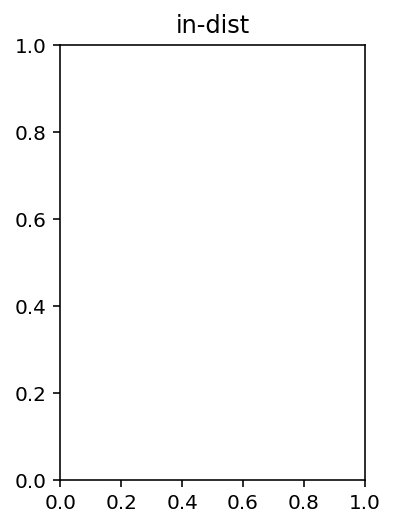

In [13]:
epis   = np.array(test_res['epis_'])
plt.subplot(1,2,1)
plt.title('in-dist')
plt.hist(epis[y_true == 0], bins=15, alpha=1 , color='r')
plt.subplot(1,2,2)
plt.title('out-of-dist')
plt.hist(epis[y_true == 1], bins=15,  alpha=0.3 , color='b')

In [ ]:
y_true = np.array(test_res['y_true'])
epis   = np.array(test_res['epis_'])
print(np.mean(epis[y_true == 0]), np.mean(epis[y_true == 1]))